In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# seeding for reproducible results
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

matplotlib.rcParams['figure.figsize'] = (24, 18)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size': 20})

TRAIN_SIZE = 9800
TRAIN_TIME = 6
BATCH_SIZE = 32
BUFFER_SIZE = 500

In [2]:
total_ped_matrix = np.load("../details/ego_ped_matrix.npy")

with open("../details/ped_dataset.pkl", 'rb') as f:
    ped_dataset = pickle.load(f)
    
with open("../details/scene_info.pkl", 'rb') as handle:
    scene_info = pickle.load(handle)

In [3]:
# nusc = NuScenes(version='v1.0-trainval', 
#                 dataroot='../../../../../data/', 
#                 verbose=False)

# so_map = NuScenesMap(dataroot='../../../../../data/', 
#                        map_name='singapore-onenorth')
# bs_map = NuScenesMap(dataroot='../../../../../data/', 
#                        map_name='boston-seaport')
# sh_map = NuScenesMap(dataroot='../../../../../data/', 
#                        map_name='singapore-hollandvillage')
# sq_map = NuScenesMap(dataroot='../../../../../data/', 
#                        map_name='singapore-queenstown')

# # dict mapping map name to map file
# map_files = {'singapore-onenorth': so_map,
#              'boston-seaport': bs_map,
#              'singapore-hollandvillage': sh_map,
#              'singapore-queenstown': sq_map}

In [4]:
# # calculating the values for standardization for every feature
# mean_values = np.mean(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))
# std_values = np.std(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))

# # standardization
# total_ped_matrix = (total_ped_matrix - mean_values) / std_values

In [5]:
# train_test split
x_train = total_ped_matrix[:TRAIN_SIZE, :, :TRAIN_TIME, :]
# reshaping into 3D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[2],
                              x_train.shape[1]*x_train.shape[3]))
y_train1 = total_ped_matrix[:TRAIN_SIZE, 0, TRAIN_TIME:, :2]
y_train2 = total_ped_matrix[:TRAIN_SIZE, 1, TRAIN_TIME:, :2]
# shape is 9800,20,2
y_train = np.append(y_train1, y_train2, axis=1)

x_test = total_ped_matrix[TRAIN_SIZE:, :, :TRAIN_TIME, :]
# reshaping into 3D
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[2],
                              x_test.shape[1]*x_test.shape[3]))
y_test1 = total_ped_matrix[TRAIN_SIZE:, 0, TRAIN_TIME:, :2]
y_test2 = total_ped_matrix[TRAIN_SIZE:, 1, TRAIN_TIME:, :2]
# shape is 2510,20,2
y_test = np.append(y_test1, y_test2, axis=1)

In [6]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [7]:
# defining the custom rmse loss function
def ttc_loss(gt_path, ego_path):
    tot_ttc = 0.0
    tot_dist = 0.0
    for i in range(gt_path.shape[0]): #batch
        del_time = 0.0
        del_dist = np.inf
        for j in range(gt_path.shape[1]): #10 timesteps
            for k in range(ego_path.shape[1]):
                gt_pos = gt_path[i,j,:]
                ego_pos = ego_path[i,k,:]
                
                dist = np.sqrt(np.sum((gt_pos - ego_pos)**2))
                if dist < del_dist:
                    del_dist = dist
                    del_time = abs(j-k)
                    
        tot_ttc += del_time
        tot_dist += del_dist
    tot_ttc = tot_ttc/float(len(gt_path))
    tot_dist = tot_dist/float(len(gt_path))
    return np.float32(tot_dist*tot_ttc)  

def model_loss(gt, pred_path):
    '''
    calculates custom rmse loss between every time point
    '''
    gt_path = gt[:,:10,:]
    rmse_error = K.mean(K.sqrt(K.sum(K.square(gt_path-pred_path), axis=1)))
    
    ego_path = gt[:,10:,:]
    ttc_error = tf.numpy_function(ttc_loss, [gt_path, ego_path], tf.float32)
    return rmse_error + (2.0/(ttc_error+0.1))

def euc_dist(gt_path, pred_path):
    # custom metric to monitor rmse
    gt_path = gt_path[:,:10,:]
    return K.mean(K.sqrt(K.sum(K.square(gt_path-pred_path), axis=1)))     

In [8]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(LSTM(32, input_shape=x_train.shape[-2:]))
lstm_model.add(RepeatVector(10))
lstm_model.add(LSTM(16, return_sequences=True,activation='relu'))
lstm_model.add(LSTM(8, return_sequences=True,activation='relu'))
lstm_model.add(TimeDistributed(
                Dense(2, activation='linear')))

lstm_model.compile(optimizer='adam', 
                       loss=model_loss, metrics=[euc_dist])

In [9]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6016      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 16)            3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 8)             800       
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 2)             18        
Total params: 9,970
Trainable params: 9,970
Non-trainable params: 0
_________________________________________________________________


In [10]:
# checkpoint for saving the best model
filepath="../checkpoints/lstm_ttc_dist_gt.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_euc_dist', 
                                                verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

train_history = lstm_model.fit(train_data, epochs=40,
                         verbose=0, callbacks=None,
                         validation_data=val_data,
                         steps_per_epoch=300,
                         validation_steps=70
                         )

In [11]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

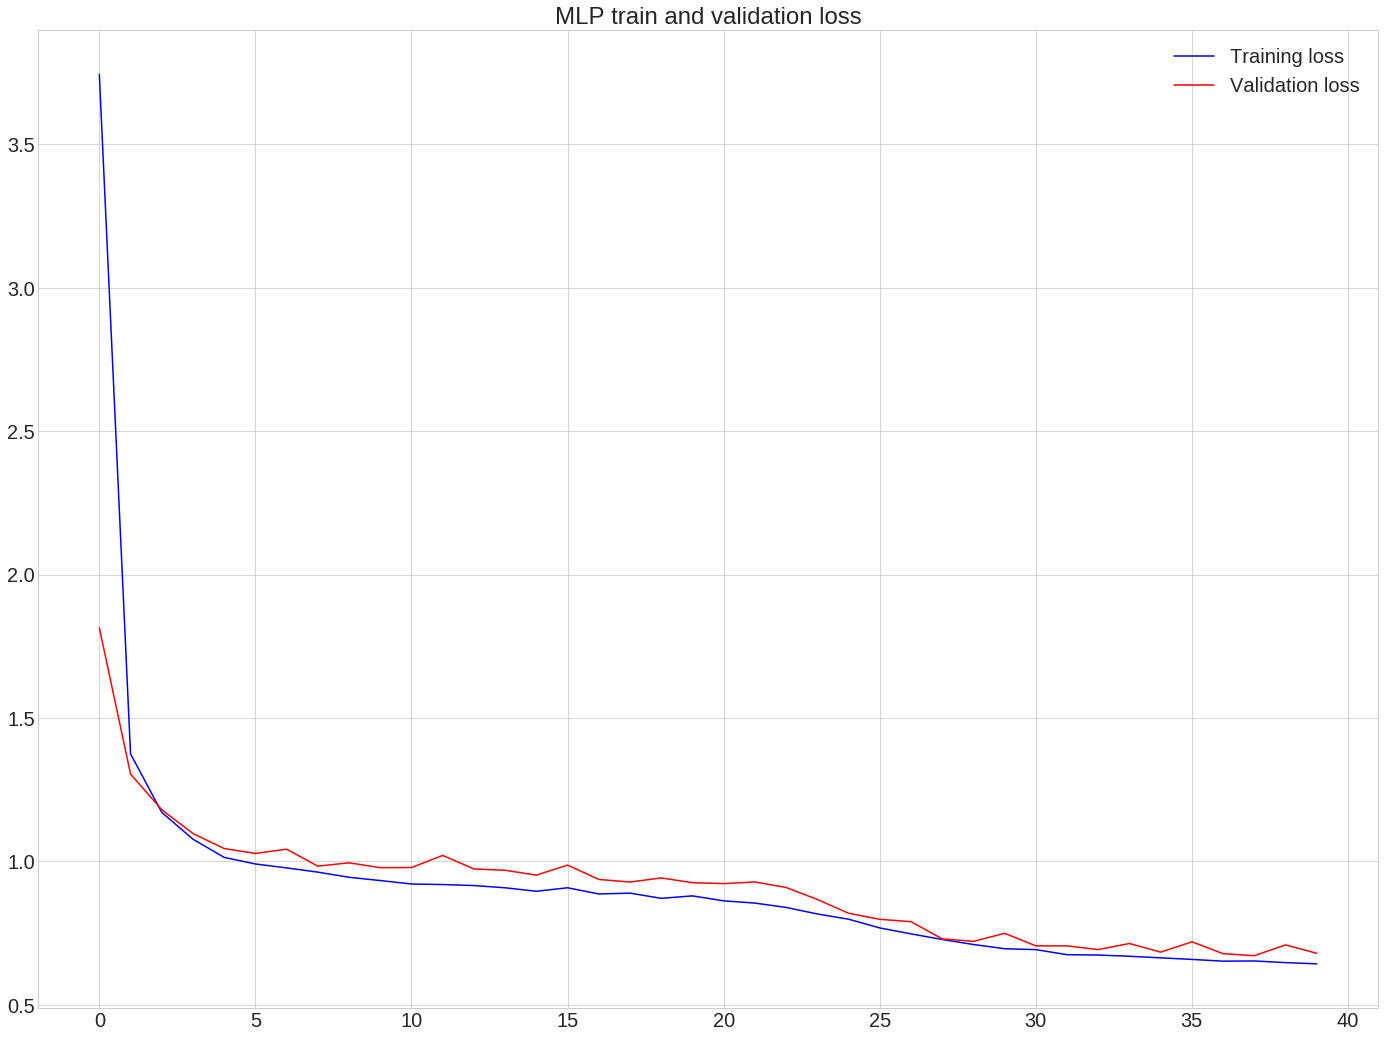

In [12]:
plot_train_history(train_history, "MLP train and validation loss")

In [13]:
# undo normalization for plotting
def move_from_origin(l, origin):
    x0, y0 = origin
    return [[x + x0, y + y0] for x, y in l]

def rotate_from_y(l, angle):
    theta = -angle
    return [(x*np.cos(theta) - y*np.sin(theta), 
                    x*np.sin(theta) + y*np.cos(theta)) for x, y in l]

# loss calculation for test prediction
def rmse_error(l1, l2):
    loss = 0.0
    
    if len(np.array(l1).shape) < 2:
        return ((l1[0] - l2[0])**2 + (l1[1] - l2[1])**2)**0.5
    for p1, p2 in zip(l1, l2):
        loss += ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5
    return (loss / float(len(l1)))

In [14]:
ade_values = []
fde_values = []

for test_idx in range(TRAIN_SIZE, len(ped_dataset)):
    test_data = total_ped_matrix[test_idx:test_idx+1,:,:6,:]
    test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2],
                                       test_data.shape[1]*test_data.shape[3]))
    predictions = lstm_model.predict(test_data).reshape(-1, 2)
    predictions = move_from_origin(rotate_from_y(predictions, ped_dataset[test_idx]["angle"]),
                                   ped_dataset[test_idx]["origin"])

#     n_scene = ped_dataset[test_idx]["scene_no"]
#     ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_egoposes_on_fancy_map(
#                     nusc, scene_tokens=[nusc.scene[n_scene]['token']], verbose=False,
#                     render_egoposes=True, render_egoposes_range=False, 
#                     render_legend=False)

#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[:6,:2]), c='k', s=5, zorder=2)
#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[6:,:2]), c='b', s=5, zorder=3)
#     plt.scatter(*zip(*predictions), c='r', s=5, zorder=4)
#     plt.show()
    
    loss = rmse_error(predictions, 
                      np.array(ped_dataset[test_idx]["translation"])[6:,:2])
    final_loss = rmse_error(predictions[-1], 
                            np.array(ped_dataset[test_idx]["translation"])[-1,:2])

    
#     print(f"Loss in m is {loss}")
#     print(f"Loss of final position in m is {final_loss}")
    
    ade_values.append(loss)
    fde_values.append(final_loss)
    
print(np.mean(np.array(ade_values)))
print(np.mean(np.array(fde_values)))

0.2986622909962153
0.5110788555060514
